# **Stock market news feed semantic analysis** *(Baseline LSTM)*

## **A projekt előkészítése**

A Drive csatlakoztatása a szükséges fájlok későbbi betöltésére.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


A reddit-es híreket tartalmazó dataset beolvasása. Ez az adathalmaz nem saját adathalamaz, forrás: Sun, J. (2016, August). Daily News for Stock Market Prediction, Version 1. Retrieved 2021.02.19. from https://www.kaggle.com/aaron7sun/stocknews

In [ ]:
# Copy the dataset to the local environment
!cp "/content/drive/MyDrive/Combined_News_DJIA.csv" "Combined_News_DJIA.csv"

In [ ]:
# Check the copy is succesfull -> good if no assertation error
read = !ls
assert read[0].find("Combined_News_DJIA.csv") != -1

Látható, hogy a torchtext verziója nem megfelelő az alkalmazásra, ezért frissítem.

In [ ]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 4.2MB/s 
     |████████████████████████████████| 1.2MB 9.3MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


A szükséges könyvtárak betöltése a projekt egészéhez.

In [ ]:
# Import the libraries 
import pandas as pd
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt
import string
import time
import torch.optim as optim
import torch.nn as nn
import torch
from torchtext import data
from sklearn.utils import shuffle
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize  
from wordcloud import WordCloud
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import sklearn.metrics as metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


A következőkben a projektben használt makrókat definiálom.

In [ ]:
# Number of merged news into one string
ROWS = 1

# The label column 
LABEL_COLUMN = 0

# Shuffle cycle number for the dataframe
SHUFFLE_CYCLE = 500

# Numpy random seed
NP_SEED = 1234

# Torch seed
TORCH_SEED = 1234

# Train percentage (train + valid)
TRAIN_SPLIT = 0.8

# Only validation split
VALIDATION_SPLIT = 0.1

# Vocabulary size
MAX_VOCAB_SIZE = 7500

# Batch size for input
BATCH_SIZE = 64

# LSTM embedding layer dimension
EMBEDDING_DIM = 100

# LSTM hidden layer dimension
HIDDEN_DIM = 64

# LSTM output layer dimension
OUTPUT_DIM = 1

# LSTM layer(s) number
N_LAYERS = 2

# LSTM bidirectional choose
BIDIRECTIONAL = False

# LSTM dropout
DROPOUT = 0.1

# Epoch number
N_EPOCHS = 100

# Create new vocab
NEW_VOCAB = True

# Freeze embedding layer weigths
FREEZE_EMB = False

# n value of n-gram model
N_GRAM = True
N_VALUE_RANGE_START = 1
N_VALUE_RANGE_END = 3

A random generátorok seed-jének beállítása a projekt eredményeinek reprodukálhatósága érdekében.

In [ ]:
rs = RandomState(MT19937(SeedSequence(NP_SEED)))
torch.manual_seed(TORCH_SEED)
np.random.seed(NP_SEED)

Globális változók beállítása a determinisztikus futás és a reprodukálhatóság érdekében.

In [ ]:
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
  torch.cuda.manual_seed_all(TORCH_SEED)

## **A hírek szentimentális analízise**

### A szöveg előkészítése

A reddit-es híreket tartalmazó adathalmaz betöltése. A hírek 2008-08-08-tól 2016-07-01-ig tartanak.

In [ ]:
# Load the dataset 
df_combined = pd.read_csv('Combined_News_DJIA.csv', index_col = "Date")

# Show the dataframe
df_combined

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel c

A következőkben az esetleges adat nélküli napokat, illetve cellákat keresem meg és helyettesítem őket egy üres sztringgel. Ez a későbbi szövegfeldolgozás hibamentességéhez szükséges. Először a keresés következik.

In [ ]:
# Find the cells with NaN and after the rows for them
is_NaN = df_combined.isnull()
row_has_NaN = is_NaN.any(axis = 1)
rows_with_NaN = df_combined[row_has_NaN]

rows_with_NaN

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-09-15,1,b'The Church of Scientology won\'t be dissolve...,b'New virus from rats can kill 80 per cent of ...,b'The gruesome spectacle of dolphins being sla...,b'The End of Innocence in Afghanistan: \'The G...,b'France approves Internet piracy bill',b'The Rural Doctors Association says right now...,b'Al Jazeera English - Africa - Shabab to aven...,"b""How Sri Lanka governs through detentions - S...",b'Two months after the Pakistani Army wrested ...,b'N. Korean cargo ship repels pirates off Soma...,b'Canada: Stephen Harper attempts to prop up r...,b'New geological data provides hope for claims...,b'Ukraine set to block Elton John adoption bec...,b'German plane makes emergency landing',b'Street artist catches chief of the Israeli a...,b'In an equine echo of the controversy surroun...,b'UPDATE: 5-New York homes raided in terrorism...,b'Population Growth Impeding Progress on the M...,b'Global Population to Reach 7 Billion by 2011',b'Government Funded Feminist Porn ',b'Can someone enlighten me re:Holy Land disput...,b'Human Rights Watch official suspended for co...,NaN,NaN,NaN
2009-12-24,1,b'Woman knocks down Pope Benedict at Christmas...,b'Ugandan President Museveni says he will bloc...,"b""Venezuela's Chavez threatens to kick out car...",b'Woman who knocked down pope had pasta in her...,"b'450 people from 21 countries, including 30 f...",b'Chvez declares Angel Falls is no more: World...,b'Drug tests catch out 10 police (UK)',"b'Once the worlds fourth-largest lake, the Ara...","b""Cool Saudi Feminist calls for woman's right ...","b'According to satellite surveys, as much as 8...",b'Italian Prime Minister Silvio Berlusconi has...,"b""Don't blame the system for winter travel cha...",b'Christmas Eve around the world included the ...,b'Pope knocked down before Xmas mass',b'The solar salesman who put his cow on the ma...,b'Pig farts spark Australia gas scare - I shit...,b'Bin Laden daughter flees to Saudi embassy in...,b'Traumatic Brain Injuries: Growing evidence ...,b'The Pakistan Supreme Court has ordered the P...,"b""Here's a video the Taliban released this mor...",b'Fireworks set off aboard airliner',"b'Five VA men may face terrorism charges, Paki...","b""Ayatollah Montazeri's Legacy: In death he m...",NaN,NaN
2011-04-21,1,"Director of ""Restrepo"" and Photographer Chris ...",Everyone within 20km of Fukushima will be forc...,Bahrain: Activist Zaynab Al-Khawaja's letter t...,"More than 80,000 people are claiming incapacit...",Libya: 'mission creep' claims as UK sends in m...,Japan considers banning access to evacuation zone,Chinese oil giant Sinopec has stopped exportin...,6.0-magnitude earthquake strikes off east coas...,Next war in line: At least 20 South Sudanese a...,Bahraini protester ends hunger strike after be...,China tries to scare motorists into safer driving,Leaked Report Shows England Hit With Three Nuc...,Japans cyclone season approaches.,Have Oman and Qatar escaped the Arab revolts?,Rioters torch Australia asylum seeker detentio...,Russian migration official fired in racism row...,Small amounts of radioactive iodine found in b...,"War photographer, Oscar-nominated film directo...",Effeminate boys are being sent to a special ca...,Japan Government Declares 12-Mile Area Around ...,TEPCO admitted Wednesday that nuclear fuel in ...,Fukushima evacuees face arrest if they return ...,Prince Charles wins some kind of a record,NaN,NaN


Az üres cellák kicserélése üres sztringekre, majd annak ellenőrzése, hogy nincs már üres cella. Erre a célra assert függvényt használok, ha lenne esetleg üres cella, akkor azt assertation hibaüzenet jelezné.

In [ ]:
# Replace them
df_combined = df_combined.replace(np.nan, " ")

# Check the process
is_NaN = df_combined.isnull()
row_has_NaN = is_NaN.any(axis = 1)
rows_with_NaN = df_combined[row_has_NaN]

assert len(rows_with_NaN) is 0

# Show the dataset
df_combined

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel c

Ezek után az egy naphoz tartozó híreket közös sztringekbe fűzöm. Az egy sztringbe tartozó hírek számát makróval definiálom:


*   ROWS - egymásba fűzött hírek száma

Itt megtalálható már az első előkészítő algoritmusom, méghozzá a sztringek elején található b karakter eltávolítása.



In [ ]:
# Get column names
combined_column_names = []
for column in df_combined.columns:
  combined_column_names.append(column)

# 2D array creation for the news based on macros
COLUMNS = len(df_combined)
news_sum = [[0 for i in range(COLUMNS)] for j in range(int((len(combined_column_names) - 1) / ROWS))]  

# Show the column names
print("Column names of the dataset:") 
print(combined_column_names)

# Merge the news
for row in range(len(df_combined)):
  for column in range(int((len(combined_column_names) - 1) / ROWS)):
    temp = ""
    news = ""
    for word in range(ROWS):
      news = df_combined[combined_column_names[(column * ROWS) + (word + 1)]][row]
      # Remove the b character at the begining of the string
      if news[0] is "b":
        news = " " + news[1:]
      temp = temp + news
    news_sum[column][row] = temp

# Show the first day second package of the news
print("\nThe first day second package of the news:")
print(news_sum[1][0])

Column names of the dataset:
['Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25']

The first day second package of the news:
 'BREAKING: Musharraf to be impeached.'


Ezek után a korábbi oszlopokat(Top1, Top2...) kicserélem a csoportosításnak megfelelő számú oszlopokra és nevekre (News_1, News_2...), majd feltöltöm őket az összevont hírcsomagokkal.

In [ ]:
# Drop the old columns
for column in range(len(combined_column_names) - 1):
  df_combined.drop(combined_column_names[column + 1], axis = 1, inplace = True)

# Create the new columns with the merged news
for column in range(int((len(combined_column_names) - 1) / ROWS)):
  colum_name = "News_" + str(column + 1)
  df_combined[colum_name] = news_sum[column]

# Show the DataFrame
df_combined

,Label,News_1,News_2,News_3,News_4,News_5,News_6,News_7,News_8,News_9,News_10,News_11,News_12,News_13,News_14,News_15,News_16,News_17,News_18,News_19,News_20,News_21,News_22,News_23,News_24,News_25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"""Georgia 'downs two Russian warplanes' as cou...",'BREAKING: Musharraf to be impeached.','Russia Today: Columns of troops roll into So...,'Russian tanks are moving towards the capital...,"""Afghan children raped with 'impunity,' U.N. ...",'150 Russian tanks have entered South Ossetia...,"""Breaking: Georgia invades South Ossetia, Rus...","""The 'enemy combatent' trials are nothing but...",'Georgian troops retreat from S. Osettain cap...,'Did the U.S. Prep Georgia for War with Russia?','Rice Gives Green Light for Israel to Attack ...,'Announcing:Class Action Lawsuit on Behalf of...,"""So---Russia and Georgia are at war and the N...","""China tells Bush to stay out of other countr...",'Did World War III start today?','Georgia Invades South Ossetia - if Russia ge...,'Al-Qaeda Faces Islamist Backlash',"'Condoleezza Rice: ""The US would not act to p...",'This is a busy day: The European Union has ...,"""Georgia will withdraw 1,000 soldiers from Ir...",'Why the Pentagon Thinks Attacking Iran is a ...,'Caucasus in crisis: Georgia invades South Os...,'Indian shoe manufactory - And again in a se...,'Visitors Suffering from Mental Illnesses Ban...,"""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,'Why wont America and Nato help us? If they w...,'Bush puts foot down on Georgian conflict',"""Jewish Georgian minister: Thanks to Israeli ...",'Georgian army flees in disarray as Russians ...,"""Olympic opening ceremony fireworks 'faked'""",'What were the Mossad with fraudulent New Zea...,'Russia angered by Israeli military sale to G...,'An American citizen living in S.Ossetia blam...,'Welcome To World War IV! Now In High Definit...,"""Georgia's move, a mistake of monumental prop...",'Russia presses deeper into Georgia; U.S. say...,'Abhinav Bindra wins first ever Individual Ol...,' U.S. ship heads for Arctic to define territ...,'Drivers in a Jerusalem taxi station threaten...,'The French Team is Stunned by Phelps and the...,'Israel and the US behind the Georgian aggres...,"'""Do not believe TV, neither Russian nor Geor...",'Riots are still going on in Montreal (Canada...,'China to overtake US as largest manufacturer','War in South Ossetia [PICS]','Israeli Physicians Group Condemns State Tort...,' Russia has just beaten the United States ov...,'Perhaps *the* question about the Georgia - R...,'Russia is so much better at war',"""So this is what it's come to: trading sex fo..."
2008-08-12,0,'Remember that adorable 9-year-old who sang a...,"""Russia 'ends Georgia operation'""","'""If we had no sexual harassment we would hav...","""Al-Qa'eda is losing support in Iraq because ...",'Ceasefire in Georgia: Putin Outmaneuvers the...,'Why Microsoft and Intel tried to kill the XO...,'Stratfor: The Russo-Georgian War and the Bal...,"""I'm Trying to Get a Sense of This Whole Geor...","""The US military was surprised by the timing ...",'U.S. Beats War Drum as Iran Dumps the Dollar',"'Gorbachev: ""Georgian military attacked the S...",'CNN use footage of Tskhinvali ruins to cover...,'Beginning a war as the Olympics were opening...,'55 pyramids as large as the Luxor stacked in...,'The 11 Top Party Cities in the World','U.S. troops still in Georgia (did you know t...,'Why Russias response to Georgia was right',"'Gorbachev accuses U.S. of making a ""serious ...","'Russia, Georgia, and NATO: Cold War Two'",'Remember that adorable 62-year-old who led y...,'War in Georgia: The Israeli connection','All signs point to the US encouraging Georgi...,'Christopher King argues that the US and NATO...,'America: The New Mexico?',"""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2008-08-13,0,' U.S. refuses Israel weapons to attack Iran:...,"""When the president ordered to attack Tskhinv...",' Israel clears troops who killed Reut

Az első napi összefűzött hírcsomagok közüli első csomagnak a kiíratása következik.

In [ ]:
df_combined["News_1"][0]

' "Georgia \'downs two Russian warplanes\' as countries move to brink of war"'

Egy új dataframebe újracsoportosítom a hír blokkokat a címkéjükkel, már a dátumok nélkül.

In [ ]:
news_sum = []
label_sum = []

# Get the column names
combined_column_names = []
for column in df_combined.columns:
  combined_column_names.append(column)

# Write out the column names 
print(combined_column_names)
print("\n")

# Connect the merged news with the labels
for column in range(len(df_combined)):
  for row in range(len(combined_column_names) - 1):
    news_sum.append(df_combined[combined_column_names[row + 1]][column])
    label_sum.append(df_combined[combined_column_names[LABEL_COLUMN]][column])

# Create the new DataFrame
df_sum_news_labels = pd.DataFrame(data = label_sum, index = None, columns = ["Label"])
df_sum_news_labels["News"] = news_sum

# Show it
df_sum_news_labels


['Label', 'News_1', 'News_2', 'News_3', 'News_4', 'News_5', 'News_6', 'News_7', 'News_8', 'News_9', 'News_10', 'News_11', 'News_12', 'News_13', 'News_14', 'News_15', 'News_16', 'News_17', 'News_18', 'News_19', 'News_20', 'News_21', 'News_22', 'News_23', 'News_24', 'News_25']




,Label,News
0,0,"""Georgia 'downs two Russian warplanes' as cou..."
1,0,'BREAKING: Musharraf to be impeached.'
2,0,'Russia Today: Columns of troops roll into So...
3,0,'Russian tanks are moving towards the capital...
4,0,"""Afghan children raped with 'impunity,' U.N. ..."
...,...,...
49720,1,Philippines president Rodrigo Duterte urges pe...
49721,1,Spain arrests three Pakistanis accused of prom...
49722,1,"Venezuela, where anger over food shortages is ..."
49723,1,A Hindu temple worker has been killed by three...


A következőkben a hírek szövegeinek kódolása történik numerikus értékekre. Először a szövegek előfeldolgozásával kezdem: írásjelek eltávolítása, számok eltávolítása, felesleges szóközök eltávolítása, aztán minden szót kis kezdőbetűjü szóvá konvertálom.

In [ ]:
# Removing punctuations
temp_news = []
for line in news_sum:
  temp_attach = ""
  for word in line:
    temp = " "
    if word not in string.punctuation:
      temp = word
    temp_attach = temp_attach + "".join(temp)
  temp_news.append(temp_attach)

news_sum = temp_news
temp_news = []

# Remove numbers
for line in news_sum:
  temp_attach = ""
  for word in line:
    temp = " "
    if not word.isdigit():
      temp = word
    temp_attach = temp_attach + "".join(temp)
  temp_news.append(temp_attach)

# Remove space
for line in range(len(temp_news)):    
  temp_news[line] = " ".join(temp_news[line].split())

# Converting headlines to lower case
for line in range(len(temp_news)): 
    temp_news[line] = temp_news[line].lower()

# Update the data frame
df_sum_news_labels["News"] = temp_news

# Show it
df_sum_news_labels

,Label,News
0,0,georgia downs two russian warplanes as countri...
1,0,breaking musharraf to be impeached
2,0,russia today columns of troops roll into south...
3,0,russian tanks are moving towards the capital o...
4,0,afghan children raped with impunity u n offici...
...,...,...
49720,1,philippines president rodrigo duterte urges pe...
49721,1,spain arrests three pakistanis accused of prom...
49722,1,venezuela where anger over food shortages is s...
49723,1,a hindu temple worker has been killed by three...


Az első napi, előfeldolgozott, összefűzött hírek első csoportja.

In [ ]:
df_sum_news_labels["News"][1]

'breaking musharraf to be impeached'

A következőkben az úgy nevezett töltelék szavakat (stop words) fogom eltávolítani.

In [ ]:
# Load the stop words
stop_words = set(stopwords.words('english'))

filtered_sentence = []
news_sum = df_sum_news_labels["News"]

# Remove stop words
for line in news_sum:
  word_tokens = word_tokenize(line)
  temp_attach = ""
  for word in word_tokens:
    temp = " "
    if not word in stop_words:
      temp = temp + word
    temp_attach = temp_attach + "".join(temp)
  filtered_sentence.append(temp_attach)

# Remove space
for line in range(len(filtered_sentence)):    
  filtered_sentence[line] = " ".join(filtered_sentence[line].split())

# Update the data frame
df_sum_news_labels["News"] = filtered_sentence

# Show the DataFrame
df_sum_news_labels

,Label,News
0,0,georgia downs two russian warplanes countries ...
1,0,breaking musharraf impeached
2,0,russia today columns troops roll south ossetia...
3,0,russian tanks moving towards capital south oss...
4,0,afghan children raped impunity u n official sa...
...,...,...
49720,1,philippines president rodrigo duterte urges pe...
49721,1,spain arrests three pakistanis accused promoti...
49722,1,venezuela anger food shortages still mounting ...
49723,1,hindu temple worker killed three men motorcycl...


Az előbbi hírcsomag kiírása összehasonlításképp a töltelékszavak eltávolítása után.

In [ ]:
df_sum_news_labels["News"][5000]

'fuck n korea warns possible military strike longer bound armistice'

Az adathalmazban lévő nulla hosszú sztring csomagok megkeresése és a hozzájuk tartozó cellák törlése következik.

In [ ]:
news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1

print(null_indexes)

for row in null_indexes:
  df_sum_news_labels = df_sum_news_labels.drop(row)

news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1
  
assert len(null_indexes) is 0

[6947, 6948, 6949, 8723, 8724, 13134, 17048, 17049]


Ezek után kicsit megvizsgálom az előfeldolgozott adathalmazom. Először is megvizsgálom a címkék arányát az adathalmazban, hisz az befolyásolni tudja a későbbi klasszifikáció pontosságát.

In [ ]:
# Groupby by label
labels = df_sum_news_labels.groupby("Label")

# Summary statistic of all countries
labels.describe().head()

News                                                               
       count unique                                                top freq
Label                                                                      
0      23100  23079                                    dark side dubai    2
1      26617  26591  iceland declares independence international banks    3

A százalékos arány megvizsgálása., illetve annak ellenőrzése, hogy beleesnek-e 45%...55% tartományba. Ha nem esnek bele, akkor azt assertation hibaüzenettel jelzem.

In [ ]:
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

assert percentage_0 < 0.55 
assert percentage_0 > 0.45 

0 Labels percentage: 46.46%

1 Labels percentage: 53.54%


A következőkben egy szófelhőt fogok létrehozni a töltelékszavak nélkül. Ehhez először az összes szöveget egybefűzöm és szavakra bontom.

In [ ]:
# Get all the words
text_all = " ".join(news for news in df_sum_news_labels.News)
print ("There are {} words in the combination of all news.".format(len(text_all)))

There are 4218646 words in the combination of all news.


Majd a továbbiakban létrehozom a szófelhőt és megjelenítem.

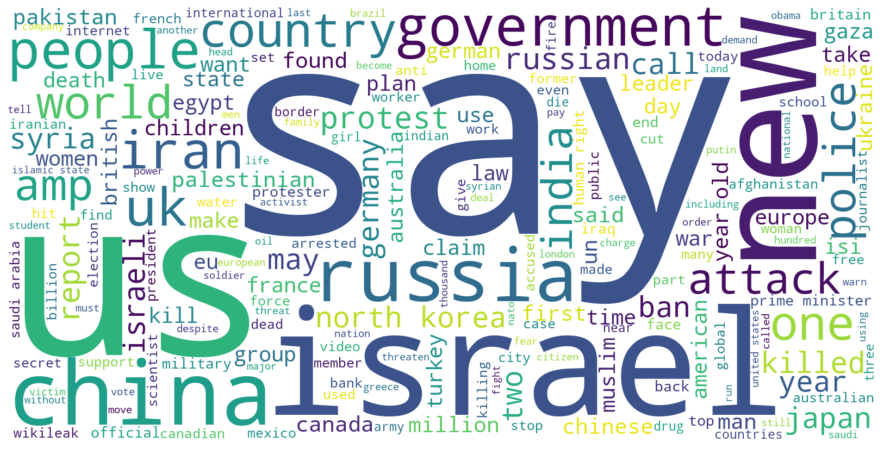

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(width=1600, height=800, background_color = "white").generate(text_all)

# Display the generated image
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

Az adathalmaz véletlenszerű sorbarendezése.

In [ ]:
# Do the shuffle
for i in range(SHUFFLE_CYCLE):
  df_sum_news_labels = shuffle(df_sum_news_labels, random_state = rs)

# Reset the index
df_sum_news_labels.reset_index(inplace=True, drop=True)

# Show the data frame
df_sum_news_labels

,Label,News
0,1,uk acts prevent arrest pope gov worried plans ...
1,1,new philippine cyber law could numb net
2,0,israel palestinians resume direct talks
3,0,sudanese woman accused adultery sentenced deat...
4,0,burma trying build nuclear weapon
...,...,...
49712,1,greece suffered another sovereign downgrade we...
49713,0,israel surprise iran maybe years public specul...
49714,1,ukrainian army appears fired cluster munitions...
49715,0,criminal gangs contaminating democracy mexico ...


Az adathalmazom felbontása tanító, validáló és teszt adathalmazra. 72% tanító, 8% validáló és 20% teszt adathalmazra.

In [ ]:
# Create datasets
news_string = (df_sum_news_labels['News'].values).astype('U')
 
INPUT_SIZE = len(df_sum_news_labels)
# 80% train -> 9% valid, 81% train; 10% test
TRAIN_SIZE = int(TRAIN_SPLIT * INPUT_SIZE) 
VALID_SIZE = int(VALIDATION_SPLIT * TRAIN_SIZE)

# Show the lengths
print(INPUT_SIZE, TRAIN_SIZE, VALID_SIZE)

49717 39773 3977


In [ ]:
# Create the train data set
train_dataset = df_sum_news_labels[:TRAIN_SIZE - VALID_SIZE] 

# Show it
train_dataset

,Label,News
0,1,uk acts prevent arrest pope gov worried plans ...
1,1,new philippine cyber law could numb net
2,0,israel palestinians resume direct talks
3,0,sudanese woman accused adultery sentenced deat...
4,0,burma trying build nuclear weapon
...,...,...
35791,1,crisis struck russian stocks worth less micros...
35792,1,love forever like always long living baby robe...
35793,0,frances national assembly shows support legali...
35794,1,german kindergartens ordered pay copyright son...


A tanító halmaz címkéinek arányát vizsgálom meg a következőkben a korábbiakhoz hasonlóan.

In [ ]:
# Groupby by label
labels = train_dataset.groupby("Label")

# Summary statistic of all countries
labels.describe().head()

News                                                         
       count unique                                          top freq
Label                                                                
0      16675  16662  china blocks internet access new york times    2
1      19121  19110   nigerian finance minister mother kidnapped    2

In [ ]:
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

assert percentage_0 < 0.55 
assert percentage_0 > 0.45 

0 Labels percentage: 46.58%

1 Labels percentage: 53.42%


In [ ]:
# Create the validation data set
valid_dataset = df_sum_news_labels[TRAIN_SIZE - VALID_SIZE:TRAIN_SIZE] 

# Show it
valid_dataset

,Label,News
35796,1,poland build russia border towers kaliningrad
35797,1,police attack protesters greek general strike ...
35798,0,nasa warns closest ever asteroid pass earth ne...
35799,1,know god rwanda shook hands devil
35800,1,video south korean ferry captain rescued under...
...,...,...
39768,0,world worst human rights observer arab league ...
39769,1,gadaffi private zoo liberated volunteers race ...
39770,0,japanese whaling fleet filmed dead minke whale...
39771,0,gunmen killed female polio worker injured anot...


A validáló adathalmaz címkéinek az arányát vizsgálom meg ezek után.

In [ ]:
# Groupby by label
labels = valid_dataset.groupby("Label")

# Summary statistic of all countries
labels.describe().head()

News                                                               
      count unique                                                top freq
Label                                                                     
0      1830   1830  archaeologists explore war torn syria turkey b...    1
1      2147   2147  network anti isis commando cells carried hundr...    1

In [ ]:
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

0 Labels percentage: 46.01%

1 Labels percentage: 53.99%


In [ ]:
# Create the test data set
test_dataset = df_sum_news_labels[TRAIN_SIZE:]

# Show it
test_dataset

,Label,News
39773,1,india wonder whether countrymen take joke jay ...
39774,0,epidemic stabbings doctors china doctor harbin...
39775,0,british isis fighter called superman returned ...
39776,0,cia tortured al qaeda suspects close point dea...
39777,0,north korean defector details human experiment...
...,...,...
49712,1,greece suffered another sovereign downgrade we...
49713,0,israel surprise iran maybe years public specul...
49714,1,ukrainian army appears fired cluster munitions...
49715,0,criminal gangs contaminating democracy mexico ...


Végül a teszt adathalmaz címkéit tekintem át.

In [ ]:
# Groupby by label
labels = test_dataset.groupby("Label")

# Summary statistic of all countries
labels.describe().head()

News                                                               
      count unique                                                top freq
Label                                                                     
0      4595   4594                   icelandic girl fights right name    2
1      5349   5349  internet traffic wikipedia pages summarizing k...    1

In [ ]:
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

assert percentage_0 < 0.55 
assert percentage_0 > 0.45 

0 Labels percentage: 46.21%

1 Labels percentage: 53.79%


Ezek lementése .tsv fájlokba, hogy majd betölthessem a pyTorch modulnak a későbbiekben.

In [ ]:
# Save them without the indexes
train_dataset.to_csv('drive/MyDrive/train.tsv', sep = '\t', index=False)
valid_dataset.to_csv('drive/MyDrive/valid.tsv', sep = '\t', index=False)
test_dataset.to_csv('drive/MyDrive/test.tsv', sep = '\t', index=False)

### Szótár létrehozása

Az n-gram modell létrehozását segítő függvény definiálása.

In [ ]:
def generate_ngrams(input):
    n_grams = []
    n_values = []
    output = []

    for n_value in range(N_VALUE_RANGE_START, N_VALUE_RANGE_END + 1):
        n_values.append(n_value)

    for n_value in n_values:
        n_grams.append(set(zip(*[input[i:] for i in range(n_value)])))

    for n_gram in n_grams:
        for element in n_gram:
            output.append(' '.join(element))

    return output

Az algoritmus tesztelése.

In [ ]:
generate_ngrams(['This', 'stock', 'is', 'stronk'])

['is',
 'This',
 'stock',
 'stronk',
 'stock is',
 'This stock',
 'is stronk',
 'stock is stronk',
 'This stock is']

A kódolandó szövegek és a címkék formátumának a megadása. Az n-gram modell beállítása is itt történik.

In [ ]:
NEWS = data.Field(#tokenize = 'spacy', 
                  preprocessing = generate_ngrams,
                  #tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABELS = data.LabelField(dtype = torch.float)

Az adathalmazok betöltése a pyTorch modulhoz.

In [ ]:
fields = [('labels', LABELS), ('news', NEWS)]

In [ ]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = "drive/MyDrive",
                                        train = "train.tsv",
                                        validation = "valid.tsv",
                                        test = "test.tsv",
                                        format = "tsv",
                                        fields = fields,
                                        skip_header = True
)

A betöltött adathalmazok első elemeinek a megjelenítése.

In [ ]:
print(vars(train_data[0]))
print(vars(valid_data[0]))
print(vars(test_data[0]))

{'labels': '1', 'news': ['gov', 'uk', 'plans', 'arrested', 'crimes', 'cover', 'priestly', 'hitchens', 'assaults', 'alleged', 'children', 'humanity', 'dawkins', 'worried', 'pope', 'prevent', 'arrest', 'acts', 'acts prevent', 'pope gov', 'assaults children', 'alleged cover', 'arrest pope', 'prevent arrest', 'humanity alleged', 'arrested crimes', 'priestly assaults', 'gov worried', 'crimes humanity', 'uk acts', 'plans dawkins', 'pope arrested', 'cover priestly', 'dawkins hitchens', 'hitchens pope', 'worried plans', 'priestly assaults children', 'crimes humanity alleged', 'cover priestly assaults', 'worried plans dawkins', 'prevent arrest pope', 'hitchens pope arrested', 'alleged cover priestly', 'gov worried plans', 'acts prevent arrest', 'dawkins hitchens pope', 'uk acts prevent', 'plans dawkins hitchens', 'arrested crimes humanity', 'pope gov worried', 'arrest pope gov', 'pope arrested crimes', 'humanity alleged cover']}
{'labels': '1', 'news': ['build', 'poland', 'kaliningrad', 'border

#### Előtanított vektorok letöltése és mentése

Előtanult vektorok használata a szótár létrehozásához, csak a tanító adathalmazt lehet felhasználni.

Az előtanított szó vektorok betöltése (GloVe). Forrás:Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: https://nlp.stanford.edu/pubs/glove.pdf

In [ ]:
if NEW_VOCAB is True and N_GRAM is False:
  NEWS.build_vocab(train_data, 
                  max_size = MAX_VOCAB_SIZE, 
                  vectors = "glove.840B.300d", 
                  unk_init = torch.Tensor.normal_)

  LABELS.build_vocab(train_data)

  print("Done!")

A szótárhoz tartozó vektorok elmentése, hogy legközelebb ne kelljen újra letölteni ezt a nagy adathalmazt.

In [ ]:
if NEW_VOCAB is True and N_GRAM is False:
  torch.save(NEWS.vocab.vectors, "drive/MyDrive/news_vocab_vectors.pt")

  print("Done!")

#### Előtanított vektorok betöltése

A szótárhoz tartozó vektorok betöltése következik a korábban lementett, előtanított vektorok alapján.

In [ ]:
if NEW_VOCAB is False or N_GRAM is True:
  NEWS.build_vocab(train_data,
                   max_size = MAX_VOCAB_SIZE)

  LABELS.build_vocab(train_data)

  if N_GRAM is False:
    NEWS.vocab.vectors = torch.load("drive/MyDrive/news_vocab_vectors.pt")

    print("Done!")

  print("Done!")

Done!


#### Szótár ellenőrzése és előkészítés

A létrehozott szótár ellenőrzése.

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(NEWS.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABELS.vocab)}")

Unique tokens in TEXT vocabulary: 7502
Unique tokens in LABEL vocabulary: 2


A leggyakoribb szavak és a címkék ellenőrzése.

In [ ]:
print(NEWS.vocab.freqs.most_common(20))
print(LABELS.vocab.stoi)

[('us', 2007), ('says', 1771), ('new', 1689), ('world', 1532), ('israel', 1440), ('china', 1426), ('government', 1416), ('police', 1301), ('people', 1288), ('u', 1256), ('russia', 1183), ('year', 1117), ('years', 1076), ('war', 1067), ('one', 990), ('president', 979), ('uk', 971), ('killed', 937), ('first', 918), ('iran', 903)]
defaultdict(None, {'1': 0, '0': 1})


A futtató eszköz és az iterátorok definiálása.

In [ ]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Show it
print(device)

#Set the iterators for the data
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key = lambda x: x.news, #sort by n attribute (quote)
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

cuda


A batch-ekhez tartozó iterátorok kiíratása.

In [ ]:
print('Train:')
for batch in train_iterator:
    print(batch)
    break
    
print('Valid:')
for batch in valid_iterator:
    print(batch)
    break
    
print('Test:')
for batch in test_iterator:
    print(batch)
    break

Train:

[torchtext.data.batch.Batch of size 64]
	[.labels]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
	[.news]:('[torch.cuda.LongTensor of size 83x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')
Valid:

[torchtext.data.batch.Batch of size 64]
	[.labels]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
	[.news]:('[torch.cuda.LongTensor of size 83x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')
Test:

[torchtext.data.batch.Batch of size 64]
	[.labels]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
	[.news]:('[torch.cuda.LongTensor of size 78x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')


### A modell felépítése

LSTM modell felépítése.

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        #100
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        #512
        self.rnn = nn.LSTM(embedding_dim, #input size
                          hidden_dim, #features in hidden state
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout=dropout)
    
        self.fc_out = nn.Linear(int(hidden_dim), output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), enforce_sorted=False)
        
        print(packed_embedded)

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        hidden = self.dropout(hidden[-1,:,:])

        return self.fc_out(hidden)

LSTM modell példányosítása.

In [ ]:
INPUT_DIM = len(NEWS.vocab)
PAD_IDX = NEWS.vocab.stoi[NEWS.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

A modell tanítható paramétereinek megvizsgálása.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 826,041 trainable parameters


A korábban létrehozott szótár használata a modell esetében.

In [ ]:
if N_GRAM is False:
    pretrained_embeddings = NEWS.vocab.vectors

    print(pretrained_embeddings.shape)

Az előre inicializált súlyok lecserélére az előtanítottakra.

In [ ]:
if N_GRAM is False:
    model.embedding.weight.data.copy_(pretrained_embeddings[0:MAX_VOCAB_SIZE + 2])

A térköz és az ismeretlen kódok súlyának nullára állítása.

In [ ]:
UNK_IDX = NEWS.vocab.stoi[NEWS.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7289, -0.7336,  1.5624,  ..., -0.5592, -0.4480, -0.6476],
        ...,
        [-1.7563,  0.5734, -0.1799,  ...,  0.5991,  0.4341, -1.1964],
        [ 0.1508, -0.0612,  0.6952,  ..., -0.8439,  0.8232,  1.8289],
        [ 0.8511,  0.2635,  1.4712,  ..., -1.3288, -1.5931, -0.1639]])


Esetleges üres súlyok keresése a kódoló rétegben. Ha megegyezik a szótár max nagyságával a kiírt akkor megfelelő.

In [ ]:
weights = torch.nonzero(model.embedding.weight.data, as_tuple = True)[0]

print(torch.unique(weights).shape)
print(MAX_VOCAB_SIZE)

assert list(torch.unique(weights).shape)[0] == MAX_VOCAB_SIZE

torch.Size([7500])
7500


Ha a konfiguráláskor letiltottam a kódoló réteg (embedding layer) tanítását, akkor azt itt kapcsolom ki.

In [ ]:
if FREEZE_EMB is True:
    model.embedding.weight.requires_grad = False

    print(f'The model has {count_parameters(model):,} trainable parameters')

### A modell tanításának előkészítése

A modell tanítása következik, amit először az optimalizáló függvény meghatározásával kezdem.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

Ezek után a költséggfüggvény definiálása következik, majd a modellel együtt az eszközre illesztése.

In [ ]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

A pontosság számítására használandó függvény definiálása.

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

A tanító függvény definiálása.

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # turn on drop out
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.news

        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.labels)
        
        acc = binary_accuracy(predictions, batch.labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

A modell tesztelésének definiálása.

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # turn off drop out
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.news
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.labels)
            
            acc = binary_accuracy(predictions, batch.labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Az epoch-ok idejének mérésére használt függvény definiálása.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### A modell tanítása és kiértékelése

A modell tanítása.

In [ ]:
best_valid_loss = float('inf')

no_improve_counter = 0
last_valid_acc = 0

train_loss_array = []
train_acc_array = []
valid_loss_array = []
valid_acc_array = []

for epoch in range(1):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_loss_array.append(train_loss)
    train_acc_array.append(train_acc)
    valid_loss_array.append(valid_loss)
    valid_acc_array.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/lstm_best-model.pt')

    # early leave
    no_improvements = ""

    if last_valid_acc > valid_acc:
        best_valid_loss = valid_loss
        no_improve_counter = no_improve_counter + 1
        no_improvements = "| There were no improvements on the validation set!"
    else:
        no_improve_counter = 0

    last_valid_acc = valid_acc

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s {no_improvements}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if no_improve_counter is 5:
      print(f'The model is not improving, going to stop.')
      break

    if train_acc > 0.95:
      print(f'The model training is finished.')
      break  
    
    torch.save(model.state_dict(), 'drive/MyDrive/lstm_last-model.pt')     

A streamkimeneten csak az utolsó 5000 sor látható.
        39, 38,  7,  3, 59, 60, 43, 55, 61, 41], device='cuda:0'), unsorted_indices=tensor([24, 39, 40, 57,  5, 14, 10, 56, 34, 47, 48, 35,  9, 37, 18, 38, 36, 53,
        21, 27, 46, 33, 44, 42,  0, 43,  7, 12,  1, 11,  4, 45, 26, 50, 15, 22,
        25, 28, 55, 54, 41, 63, 29, 60, 20, 16, 32, 49, 51,  2, 13, 19, 52, 31,
        17, 61, 30,  8,  3, 58, 59, 62, 23,  6], device='cuda:0'))
PackedSequence(data=tensor([[-3.2792e-01,  1.7790e+00,  9.9977e-01,  ...,  1.1302e-01,
         -2.4712e+00,  3.7711e-01],
        [-3.3909e+00, -9.3817e-01, -4.0197e-01,  ..., -1.8168e+00,
         -1.0939e+00,  5.1314e-01],
        [ 4.1159e-02,  2.3834e-03, -5.5358e-03,  ..., -3.4108e-02,
         -1.6793e-02,  3.5890e-02],
        ...,
        [ 4.1159e-02,  2.3834e-03,  0.0000e+00,  ..., -3.4108e-02,
          0.0000e+00,  3.5890e-02],
        [ 4.1159e-02,  2.3834e-03, -5.5358e-03,  ..., -3.4108e-02,
         -1.6793e-02,  3.5890e-02],
        [ 

A tanítási és validációs metrikák ábrázolása.

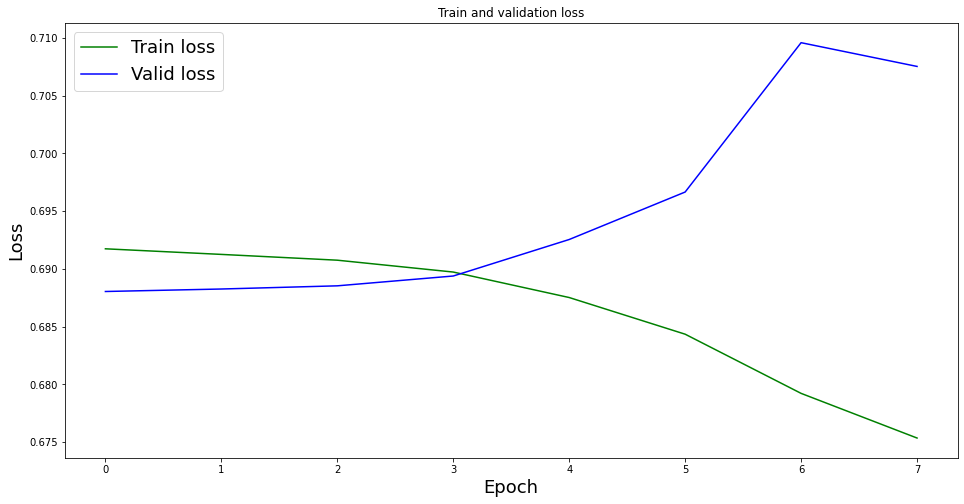

In [ ]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
plt.show()

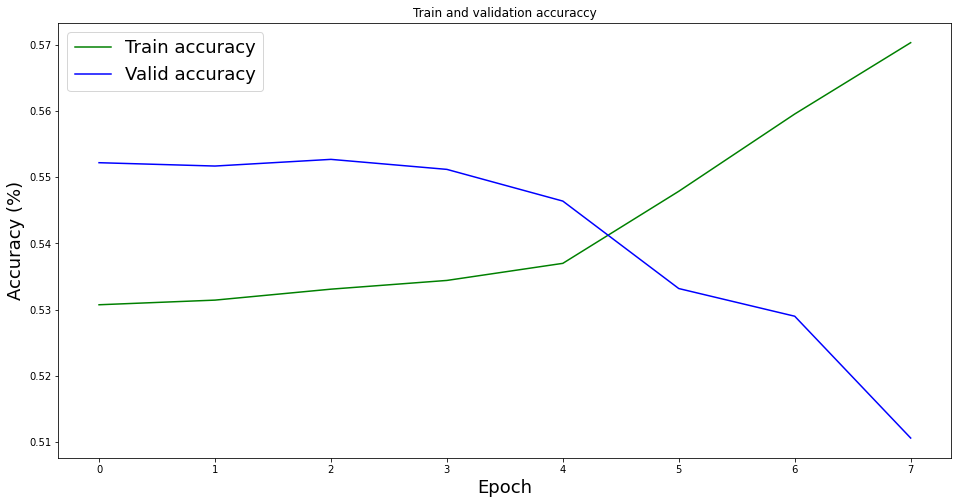

In [ ]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation accuraccy')
plt.plot(train_acc_array, color = "green", label = "Train accuracy")
plt.plot(valid_acc_array, color = "blue", label = "Valid accuracy")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy (%)',fontsize=18)
plt.legend(fontsize=18)
plt.show()

### A modell tesztelése

A modell tesztelése.

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/lstm_best-model.pt', map_location=torch.device('cpu')))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'-- Best model --')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

model.load_state_dict(torch.load('drive/MyDrive/lstm_last-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'\n-- Last model --')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

-- Best model --
Test Loss: 0.707 | Test Acc: 51.37%

-- Last model --
Test Loss: 0.711 | Test Acc: 52.35%


ROC metrika megjelenítése a legjobb modellre.

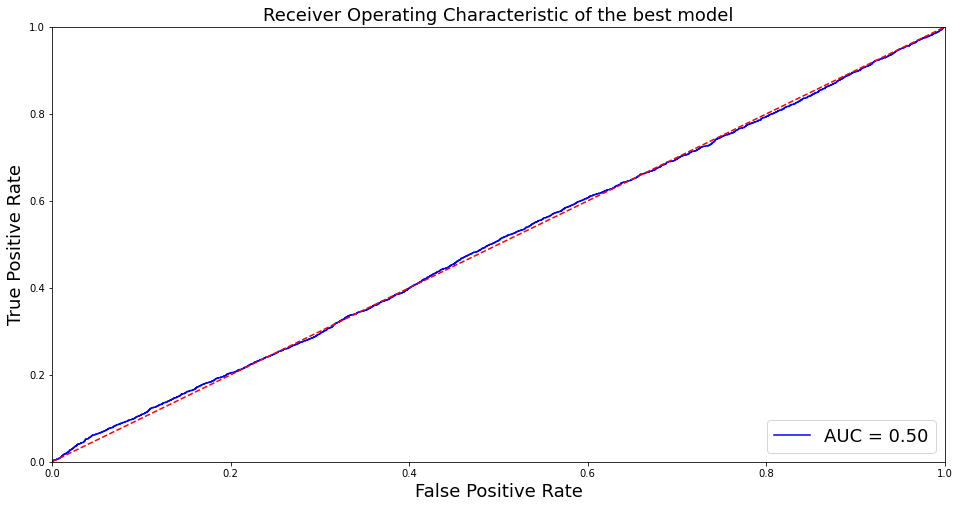

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/lstm_best-model.pt'))

model.eval() # turn off drop out

predictions = []
labels = []

# Collect predictions and labels
for batch in test_iterator:
  text, text_lengths = batch.news

  predictions.append(model(text, text_lengths).squeeze(1))

  labels.append(batch.labels)

# Convert to numpy
pred_tensor = torch.cat(predictions).cpu()
labels_tensor = torch.cat(labels).cpu()

# Get the metrics
fpr, tpr, threshold = metrics.roc_curve(labels_tensor.detach().numpy(), pred_tensor.detach().numpy())
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.figure(figsize=(16,8))
plt.title('Receiver Operating Characteristic of the best model', fontsize = 18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 18)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.show()

ROC metrika megjelenítése a legutolsó tanított modellemre.

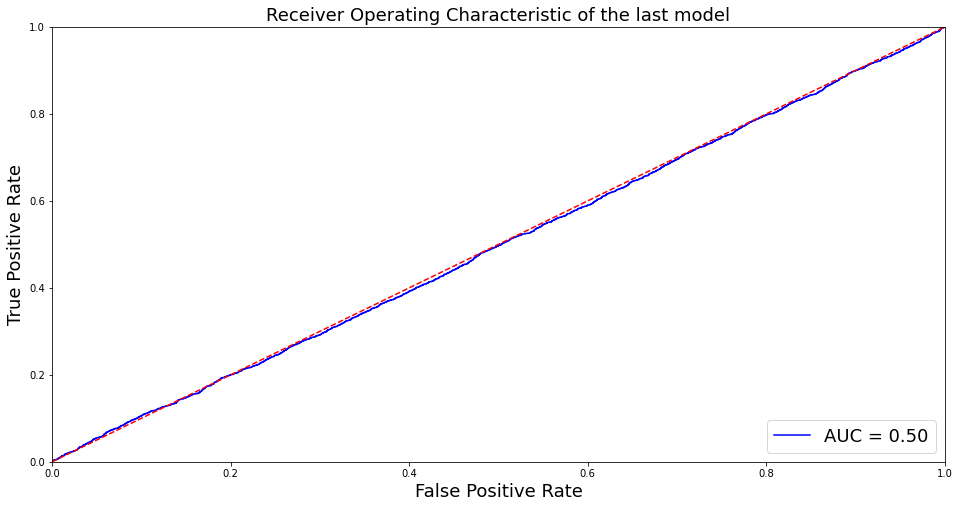

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/lstm_last-model.pt'))

model.eval() # turn off drop out

predictions = []
labels = []

# Collect predictions and labels
for batch in test_iterator:
  text, text_lengths = batch.news

  predictions.append(model(text, text_lengths).squeeze(1))

  labels.append(batch.labels)

# Convert to numpy
pred_tensor = torch.cat(predictions).cpu()
labels_tensor = torch.cat(labels).cpu()

# Get the metrics
fpr, tpr, threshold = metrics.roc_curve(labels_tensor.detach().numpy(), pred_tensor.detach().numpy())
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.figure(figsize=(16,8))
plt.title('Receiver Operating Characteristic of the last model', fontsize = 18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 18)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.show()